# Surface Algebras as Hybrid Qudit Surface Codes in Google Cirq

## Google's Plan for Surface Codes

In Google's paper in Nature [Quantum supremacy using a programmable superconducting processor](https://www.nature.com/articles/s41586-019-1666-5), they state that they "designed a quantum processor named ‘Sycamore’ which consists of a two-dimensional array of 54 transmon qubits, where each qubit is tunably coupled to four nearest neighbours, in a rectangular lattice. The connectivity was chosen to be forward-compatible with error correction using the surface code". Below, we can use Cirq, Google's quantum computing software library, to print off the layout of the Sycamore processor they used in their paper. 

In [1]:
pip show cirq

Name: cirq
Version: 0.8.1
Summary: A framework for creating, editing, and invoking Noisy Intermediate Scale Quantum (NISQ) circuits.
Home-page: http://github.com/quantumlib/cirq
Author: The Cirq Developers
Author-email: cirq@googlegroups.com
License: Apache 2
Location: /opt/anaconda3/lib/python3.7/site-packages
Requires: freezegun, pandas, protobuf, scipy, sympy, sortedcontainers, google-api-core, networkx, typing-extensions, matplotlib, numpy, requests
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cirq

In [3]:
# Version: 0.8.1

In [4]:
print(cirq.google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

So, we know the plan is to use surface codes for error correction in the future. Error correction software is both timely and relevant for moving forward with quantum computing. In this notebook we will look at how to use our library for error correction using Cirq, and how to implement surface codes for mixed qudit circuits, giving a *physical realization* of [Surface Algebras I](https://arxiv.org/abs/1810.06750) and [Surface Algebras II](https://arxiv.org/abs/1812.00621). This provides an implementation of the [Hilbert-Polya conjecture](https://en.wikipedia.org/wiki/Hilbert%E2%80%93P%C3%B3lya_conjecture) by using the Hamiltonian associated to the quantum mechanical system given by the surface code. 

In [5]:
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
from networkx import nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display
        

In [6]:
import cirq
import numpy as np
from typing import Tuple
from networkx import nx

# from qiskit import
# from src import SurfaceCodeGraph


class CirqSurfaceCodeCircuit():

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        # super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qubits = [cirq.NamedQubit(str(node)) for node in self.scgraph.code_graph.nodes]
        self.circuit = cirq.Circuit()

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

        for cycle in self.sigma:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

        for cycle in self.phi:
            self.circuit.append(cirq.H(cirq.NamedQubit(str(cycle))))

    def draw_circuit(self, render=''):
        # if render == 'mpl':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw('mpl')

        # if render == 'plain':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw()

        if render == '':
            print(self.circuit)

    def x_measurement(self, qubit):
        """Measure 'qubit' in the X-basis
        :param qubit: a name to designate a cirq.NamedQubit(str(qubit))
        :return None
        """
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.measure(cirq.NamedQubit(str(qubit))))
        self.circuit.append(cirq.H(cirq.NamedQubit(str(qubit))))

    def star_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CX gates to surrounding qubits of a star then measures star qubit in X-basis
        :param vertex:
        :return:  self.circ, self.scgraph, self.node_info
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CNOT(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))
        self.x_measurement(vertex)

    def face_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CZ gates to surrounding qubits on the boundary of a face then measures face qubit in X-basis
        :param vertex:
        :return:
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circuit.append(cirq.CZ(cirq.NamedQubit(str(vertex)), cirq.NamedQubit(str(node))))

        self.x_measurement(vertex)

    def X_1_chain(self, edges):
        """
        Pauli product X operator for arbitrary 1-cochain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(edge))))

    def Z_1_chain(self, edges):
        """
        Pauli product Z operator for arbitrary 1-chain given by
        a list of edges
        """
        for edge in edges:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(edge))))

    def product_Z(self, faces):
        """
        Pauli product Z operator for arbitrary 2-chain boundary
        """

        boundary_nodes = self.scgraph.del_2(faces)
        for node in boundary_nodes:
            self.circuit.append(cirq.Z(cirq.NamedQubit(str(node))))

    def product_X(self, stars):
        """
        Pauli product X operator for arbitrary 0-cochain coboundary
        """
        coboundary_nodes = self.scgraph.delta_1(stars)
        for node in coboundary_nodes:
            self.circuit.append(cirq.X(cirq.NamedQubit(str(node))))



    def draw_graph(self, node_type='', layout=''):
        if layout == 'spring':
            pos = nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos = nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos = nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos = nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos = nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos = nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos = nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

## Dessins and Constellations

Constructing a surface code given by an arbitrary graph embedded in a surface (i.e. a compact 2-manifold) is easy. All we need are two permutations $\sigma$ and $\alpha$. These are closely related to "dessins d'enfants", cellularly embedded graphs, "ribbon graphs", tesselations of the hyperbolic plane/Poincaré disk, Fuchsian and triangle groups, and many other very interesting mathematical objects.

"**Dessins d’enfants**" are, in the simplest terms, *bipartite* graphs embedded in a compact Riemann surface (without boundary). They are combinatorial tools used in the study of Inverse Galois Theory, orbits of the absolute Galois group of a number field, and ”Belyi functions”, which are coverings of the sphere $\mathbb{P}^1(\mathbb{C})$ ramified at most at three points, which can be assumed to be $\{0, 1, \infty \}$ (up to a Mobius transformation). One way of constructing dessins is via a combinatorial object called a ”**3-constellation**” $C = [\sigma, \alpha, \phi]$, which is a triple of permutations such that, 

1. The group $G = \langle \sigma, \alpha, \phi \rangle$, generated by the three permutations, acts transitively on $[n] = \{0, 1,2,...,n-1\}$, the set of $n$-points. 
2. The product $\sigma \alpha \phi = \mathbf{id}$, is the identity. So $\phi = (\sigma \alpha)^{-1}$.

If we restrict to the case where $\alpha$ is a fixed-point free involution, we obtain part of the standard definition of a **Brauer graph**. In the case where we do not assume this restriction, this gives a ”**hypermap**” which corresponds uniquely to a bipartite graph embedded in a compact Riemann surface and to a dessin d’enfant. Sometimes this construction is also called a "clean dessin". 

This combinatorial setup encodes a baffling amount of information even though all we start with are two permutations $\sigma$ and $\alpha$ satisfying the above two properties ($\phi$ is defined in terms of $\sigma$ and $\alpha$). In particular, we can easily compute the **Euler characteristic** of the surface in which the graph is embedded:

\begin{align}
\chi = |\sigma|-|\alpha|+|\phi| = V-E+F.
\end{align}

The reason for this is due to the following correspondence:

- $|\sigma|$ (i.e. the number of cycles in $\sigma$) is equal to the number of (black) vertices of the graph
- $|\alpha|$ is the number of edges (labeled by white nodes) of the graph
- $|\phi|$ is the number of faces of the graph

### An Example of a Constellation

A simple example of a constellation is

- $\sigma = ((0,1,2), (3,4,5))$
- $\alpha = ((0,3),(1,4),(2,5))$

From this we can compute $\phi=(0,5,1,3,2,4)$, giving us the constellation $[\sigma, \alpha, \phi]$. Computing with permutations is handled with SymPy, which is used in the class `SurfaceCodeGraph`. This class is where all of the relevant topological and combinatorial computations are done. The classes `CirqSurfaceCodeCircuit` and `QiskitSurfaceCodeCircuit` both depend on this class and refer to its methods when computing things like, 

- Syndrome Measurements
- 2-chain boundary Pauli product operators
- 0-cochain coboundary Pauli product operators
- arbitrary 1-chain and 1-cochain Pauli product operators

In particular, the class `SurfaceCodeGraph` has methods to handle computing boundaries and coboundaries of arbitrary n-chains and n-cochains, where $n = 0,1,2$. All homology and computations with n-chains and n-cochains is done over $\mathbb{Z}/2\mathbb{Z}$, which is standard in quantum surface codes. 

As an example, we can create an instance of `CirqSurfaceCodeCircuit` for the constellation above:

In [7]:
sigma = ((0,1,2),(3,4,5))
alpha = ((0,3),(1,4),(2,5))
SCC = CirqSurfaceCodeCircuit(sigma, alpha)

In [8]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 5, 1, 3, 2, 4): ───H───

(3, 4, 5): ────────────H───


In [9]:
SCC.product_Z([(0, 5, 1, 3, 2, 4)])

In [10]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───

(0, 3): ───────────────Z───

(0, 5, 1, 3, 2, 4): ───H───

(1, 4): ───────────────Z───

(2, 5): ───────────────Z───

(3, 4, 5): ────────────H───


In [11]:
SCC.product_X([(0, 1, 2)])

In [12]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───────

(0, 3): ───────────────Z───X───

(0, 5, 1, 3, 2, 4): ───H───────

(1, 4): ───────────────Z───X───

(2, 5): ───────────────Z───X───

(3, 4, 5): ────────────H───────


In [13]:
qubit = (0,1,2)
SCC.x_measurement(qubit)

In [14]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───H───M───H───

(0, 3): ───────────────Z───X───────────

(0, 5, 1, 3, 2, 4): ───H───────────────

(1, 4): ───────────────Z───X───────────

(2, 5): ───────────────Z───X───────────

(3, 4, 5): ────────────H───────────────


In [15]:
SCC.face_syndrome_measure((0, 5, 1, 3, 2, 4))

In [16]:
SCC.draw_circuit()

(0, 1, 2): ────────────H───H───M───H───────────────────

(0, 3): ───────────────Z───X───@───────────────────────
                               │
(0, 5, 1, 3, 2, 4): ───H───────@───@───@───H───M───H───
                                   │   │
(1, 4): ───────────────Z───X───────@───┼───────────────
                                       │
(2, 5): ───────────────Z───X───────────@───────────────

(3, 4, 5): ────────────H───────────────────────────────


In [17]:
SCC.Z_1_chain([(1,4), (2,5)])

In [18]:
SCC.draw_circuit()

                                       ┌──┐
(0, 1, 2): ────────────H───H───M───H──────────────────────

(0, 3): ───────────────Z───X───@──────────────────────────
                               │
(0, 5, 1, 3, 2, 4): ───H───────@───@────@─────H───M───H───
                                   │    │
(1, 4): ───────────────Z───X───────@────┼Z────────────────
                                        │
(2, 5): ───────────────Z───X────────────@─────Z───────────

(3, 4, 5): ────────────H──────────────────────────────────
                                       └──┘


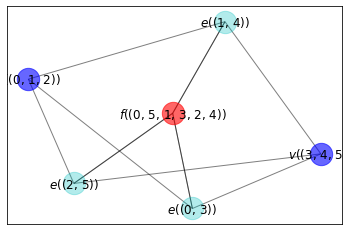

In [19]:
SCC.draw_graph('cycles', 'spring')

## Generalized Pauli Group for Qudits

While this is very useful, we would like a more general setup. In particular, we would like to have a surface code where each node represents a qudit of arbitrary dimension. We can think of this as a collection of systems, each of which is a $d_k$-level system, where the integer $d_k \geq 2$. These could be physically implemented as molecules for example. The *white nodes* given by the $2$-cycles in $\alpha$ will be $2$-level systems, i.e. *qubits*. These could be thought of as shared electrons that form molecular bonds since electrons are a typical example of a qubit. Each node represented by a cycle of $\sigma$ would then be a qudit where the dimension is determined by the length of the cycle. Similarly, for the dual dessin, the cycles of $\phi$ would also represent qudits with dimension determined by the length of the cycle. 

With this in mind we would like to define more general gates which generalize the Pauli and Clifford gates. In [Quantum Gates on Hybrid Qudits](http://zimp.zju.edu.cn/~xgwang/2003_A31012_Daboul_Wang_Barry.pdf) we see that the *Generalized Pauli Group* generated by the gates

\begin{align}
X^jZ^k, \quad & j, k \in \mathbb{Z}/d\mathbb{Z}
\end{align}

where 

\begin{align}
X^j|s\rangle &= |s+j \ (\text{mod} \ d)\rangle
\end{align}

and 

\begin{align}
Z|s\rangle &= \exp(2 \pi i s/d)|s\rangle \\
&= \zeta^s_d |s\rangle
\end{align}

where $\zeta_d = \exp(2 \pi i/d)$, form a basis for the operators on $\mathbb{H}_d = \mathbb{C}^d$. We call the group $\mathcal{P}_d = \langle X_j, Z_k \rangle$ the **Generalized Pauli Group**. The operators satisfy the following commutation relation:

\begin{align}
Z^jX^k &= \zeta_d^{jk}X^kZ^j,
\end{align}

and

\begin{align}
Z^d = X^d = I.
\end{align}

Below, we implement these as classes using Google Cirq. A specific case of the `QuditPlusGate` can be found for qutrits in the [documentation for Cirq](https://cirq.readthedocs.io/en/stable/qudits.html), which we call the `QuditXGate` here. We also implement the `QuditZGate` for qudits, the `QuditShiftGate`, and the `QuditFourierGate` which is the generalization of the Hadamard gate. The `QuditShiftGate` becomes important for implementing surface algebras. It can be represented as a matrix in the form

\begin{align}
\begin{pmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & \zeta_d \\
1 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 1 & 0 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & 0 
\end{pmatrix}.
\end{align}

This operator appears in the context of representation theory and algebraic geometry in Peter Magyar's paper [Affine Schubert Varieties and Circular Complexes](https://arxiv.org/pdf/math/0210151.pdf). They also appear in [SURFACE ALGEBRAS I: DESSINS D’ENFANTS, SURFACE ALGEBRAS, AND DESSIN
ORDERS](https://arxiv.org/pdf/1810.06750.pdf) and [SURFACE ALGEBRAS AND SURFACE ORDERS II: AFFINE BUNDLES ON CURVES](https://arxiv.org/pdf/1812.00621.pdf), where they are shown to be related to [Loop Algebras](https://en.wikipedia.org/wiki/Loop_algebra), [Loop Groups](https://en.wikipedia.org/wiki/Loop_group#:~:text=In%20its%20most%20general%20form,S1%20%E2%86%92%20G%2C%20i.e.), and [Affine Lie Algebras](https://en.wikipedia.org/wiki/Affine_Lie_algebra).

In [20]:
import cirq
import numpy as np

class QuditXGate(cirq.SingleQubitGate):
    def __init__(self, node):
        self.node = node
        self.shift_plus()
        
    def shift_plus(self):
        self.plus_gate = np.eye(N=1, M=len(self.node), k=len(self.node)-1, dtype=np.uint8)
        shift_columns = np.eye(len(self.node), k=-1)
        self.plus_gate = np.concatenate((self.plus_gate, shift_columns[1:,:]),axis=0)
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.shift_plus

    def _circuit_diagram_info_(self, args):
        return '[X]'


In [21]:
node = (1,2,3,4,5)
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditXGate(node).on(q0)
)
print(circuit)

0 (d=5): ───[X]───


In [22]:
QuditXGate(node).plus_gate

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [23]:
import cirq
import numpy as np

class QuditZGate(cirq.SingleQubitGate):
    def __init__(self, node, s):
        self.node = node
        self.s = s
        self.phase_gate()
        
        
    def phase_gate(self):
        t = np.exp(2*(self.s)*(np.pi)*1j/len(self.node))
        
        self.z_gate = np.eye(N=1, M=len(self.node))
        for j in range(1,len(self.node)):
            rows = np.eye(N=1, M=len(self.node), k=j)*(t**j)
            self.z_gate = np.vstack((self.z_gate, rows))
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.z_gate

    def _circuit_diagram_info_(self, args):
        return '[Z]'

In [24]:
node = (1,2,3)
QuditZGate(node,1).z_gate

array([[ 1. +0.j       ,  0. +0.j       ,  0. +0.j       ],
       [-0. +0.j       , -0.5+0.8660254j, -0. +0.j       ],
       [ 0. -0.j       ,  0. -0.j       , -0.5-0.8660254j]])

In [25]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditZGate(node,1).on(q0)
)
print(circuit)

0 (d=3): ───[Z]───


In [26]:
import cirq
import numpy as np

class QuditShiftGate(cirq.SingleQubitGate):
    def __init__(self, node):
        self.node = node
        self.shift_phase_plus()
        
    def shift_phase_plus(self):
        t = np.exp(2*(np.pi)*1j/len(self.node))
        self.plus_gate = np.eye(N=1, M=len(self.node), k=len(self.node)-1, dtype=np.uint8)*t
        shift_columns = np.eye(len(self.node), k=-1)
        self.phase_plus_gate = np.concatenate((self.plus_gate, shift_columns[1:,:]),axis=0)
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.shift_plus

    def _circuit_diagram_info_(self, args):
        return '[Shift]'


In [27]:
node = (1,2,3)
QuditShiftGate(node).phase_plus_gate

array([[-0. +0.j       , -0. +0.j       , -0.5+0.8660254j],
       [ 1. +0.j       ,  0. +0.j       ,  0. +0.j       ],
       [ 0. +0.j       ,  1. +0.j       ,  0. +0.j       ]])

In [28]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditShiftGate(node).on(q0)
)
print(circuit)

0 (d=3): ───[Shift]───


## Fourier Gates

Fourier gates involve the [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform). We have a [tutorial notebook on the QFT](https://github.com/The-Singularity-Research/quantum-fourier-transform). 

\begin{align}
|s) &= F|s\rangle \\
&= \frac{1}{\sqrt{d}}\sum_{k=0}^{d-1}\zeta^{sk}|k\rangle, \quad s \in \mathbb{Z}/d\mathbb{Z}
\end{align}

where 

\begin{align}
\langle s'|s) &= \frac{1}{\sqrt{d}}\zeta^{ss'}.
\end{align}

The dual states $|s)$ are related to the computational basis by a *discrete Fourier transformation*. The $F$ gate is a qudit version of the one-qubit Hadamard gate $H$. However, the $F$ operator for $d \geq 3$ is *not* Hermitian and its order is $4$ instead of $2$, unlike the usual qubit Hadamard gate

\begin{align}
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}.
\end{align}

Let's look at an example of how to construct the $F$-gate. 

In [45]:
node = (1,2,3)

t = np.exp(2*(np.pi)*1j/len(node))
print(t)

(-0.4999999999999998+0.8660254037844388j)


In [46]:
t_list = list()
for j in range(len(node)):
    t_list.append(t**j)
print(t_list)

[(1+0j), (-0.4999999999999998+0.8660254037844388j), (-0.5000000000000006-0.8660254037844385j)]


In [47]:
t_list = np.array(t_list)
t_list = np.reshape(t_list,(1,len(node)))
t_list = np.round_(t_list, decimals=5, out=None)
print(t_list)

[[ 1. +0.j      -0.5+0.86603j -0.5-0.86603j]]


In [48]:
row_list = t_list**0
for j in range(1,len(node)):
    row_list = np.vstack((row_list, t_list**j))
print(row_list)

[[ 1.        +0.j       1.        +0.j       1.        +0.j     ]
 [ 1.        +0.j      -0.5       +0.86603j -0.5       -0.86603j]
 [ 1.        +0.j      -0.50000796-0.86603j -0.50000796+0.86603j]]


We can turn this into a class so that we have a single qudit gate in Cirq as follows. 

In [49]:
import cirq
import numpy as np

class QuditFourierGate(cirq.SingleQubitGate):
    def __init__(self, node):
        self.node = node
        self.t = np.exp(2*(np.pi)*1j/len(self.node))
        self.f_gate()
        
        
    def f_gate(self):
        t_list = list()
        for j in range(len(node)):
            t_list.append(t**j)
        t_list = np.array(t_list)
        t_list = np.reshape(t_list,(1,len(node)))
        t_list = np.round_(t_list, decimals=5, out=None)
        
        row_list = t_list**0
        for j in range(1,len(node)):
            row_list = np.vstack((row_list, t_list**j))
        self.fourier_gate = row_list**(1/len(self.node))
        
    
    def _qid_shape_(self):
        return (len(self.node),)

    def _unitary_(self):
        return self.fourier_gate

    def _circuit_diagram_info_(self, args):
        return '[F]'

In [53]:
node = (1,2,3,4)

In [54]:
F = QuditFourierGate(node)

In [55]:
F.fourier_gate

array([[1.        +0.00000000e+00j, 1.        +0.00000000e+00j,
        1.        +0.00000000e+00j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 0.86602655+5.00000000e-01j,
        0.86602655-5.00000000e-01j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 0.86602655-5.00001990e-01j,
        0.86602655+5.00001990e-01j, 1.        +0.00000000e+00j],
       [1.        +0.00000000e+00j, 1.00000299-1.72357912e-06j,
        1.00000299+1.72357912e-06j, 1.        +0.00000000e+00j]])

In [35]:
q0 = cirq.LineQid(0, dimension=len(node))
circuit = cirq.Circuit(
    QuditFourierGate(node).on(q0)
)
print(circuit)

0 (d=6): ───[F]───


## Hybrid Qudit Surface Codes

In [ ]:
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
from networkx import nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display

Now, we create a class that creates a surface code circuit with qudits based on the lengths of the cycles in the dessin $[\sigma, \alpha, \phi]$. Our next goal will be to implement hybrid two-qudit gates. 

In [36]:
import cirq
import numpy as np
from typing import Tuple
from networkx import nx

# from qiskit import
# from src import SurfaceCodeGraph


class MixedSurfaceCodeCircuit():

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        # super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qubits = [cirq.NamedQubit(str(node)).with_dimension(len(node)) for node in self.scgraph.code_graph.nodes]
        self.circuit = cirq.Circuit()

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

            
    

    def draw_circuit(self, render=''):
        # if render == 'mpl':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw('mpl')

        # if render == 'plain':
        #   self.Qiskit_circ = SurfaceCodeCircuit(self.sigma, self.alpha)
        #  return self.Qiskit_circ.circ.draw()

        if render == '':
            print(self.circuit)


    def draw_graph(self, node_type='', layout=''):
        if layout == 'spring':
            pos = nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos = nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos = nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos = nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos = nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos = nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos = nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

## Physical Implementations

- [Scalable quantum computing with qudits on a graph](https://arxiv.org/pdf/1909.08973.pdf)
- [Cyclic permutations for qudits in d dimensions](https://www.nature.com/articles/s41598-019-42708-7.pdf?proof=true)
- [Practical trapped-ion protocols for universal qudit-based quantum computing](https://arxiv.org/pdf/1907.08569.pdf)

## Theoretical Background

- [Graph states of prime-power dimension from generalized CNOT quantum circuit](https://www.nature.com/articles/srep27135)
- [Improved Quantum Circuits with Qudits and Dirty Ancillae](https://www.microarch.org/micro51/SRC/posters/13_gokhale.pdf)
- [Quantum Gates on Hybrid Qudits](http://zimp.zju.edu.cn/~xgwang/2003_A31012_Daboul_Wang_Barry.pdf)
- [A SWAP gate for qudits](https://arxiv.org/pdf/1304.4923.pdf)

## Error Correction

- [Transversal Clifford gates on folded surface codes](https://www.osti.gov/servlets/purl/1333573)
- [Standard form of qudit stabilizer groups](https://arxiv.org/pdf/1101.1519.pdf)
- [Qudit surface codes and gauge theory with finite cyclic groups](https://arxiv.org/pdf/quant-ph/0609070.pdf)
- [A fast fault-tolerant decoder for qubit and qudit surface codes](https://arxiv.org/pdf/1411.3028.pdf)
- [Daniel Gottesman: Stabilizer Codes for Prime Power Qudits](https://www.youtube.com/watch?v=JWg4zrNAF-g)
- [Slides](https://www.qec14.ethz.ch/slides/DanielGottesman.pdf)

## Goggle Cirq Documentation

- [Google Cirq Qudits](https://cirq.readthedocs.io/en/stable/qudits.html)

## To Do

- Change $\mathbb{Z}/2\mathbb{Z}$ coefficients to $\mathbb{Z}/d\mathbb{Z}$ coefficients in a new `SurfaceCodeGraph` class for the more general hybrid qudit surface codes, where $d$ is the valency of a vertex. 
- Change boundary and coboundary operators and matrix differentials to match the new coefficients
- Ellaborate on the `X`, `Z`, and `Shift` operators for qudits, and show how `Shift` operators are important in surface algebras